In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_patient = pd.read_csv('data/icu_cohort_small.csv')
df_patient

,stay_id,hadm_id,subject_id,intime,outtime,icu_los_hours,gender,anchor_age,died_in_hosp
0,37302156,21819818,11417989,2140-11-02 21:07:10,2140-11-02 21:13:32,0,F,31,0
1,33255415,27790400,13941452,2161-05-21 19:34:30,2161-05-21 19:38:40,0,F,33,0
2,34040970,20991814,13447872,2140-12-21 23:12:50,2140-12-21 23:41:20,0,F,34,0
3,36502717,26958979,11331147,2142-05-14 20:10:54,2142-05-14 20:40:34,0,F,43,0
4,33084533,22087634,10971284,2189-05-19 18:42:21,2189-05-19 18:47:20,0,F,48,0
...,...,...,...,...,...,...,...,...,...
94439,31492392,24012265,18503414,2130-09-25 00:38:38,2131-01-30 21:28:57,3069,M,87,1
94440,30359303,26571961,11633737,2187-05-15 21:22:40,2187-09-28 22:04:32,3265,M,48,0
94441,39510663,22329603,18744840,2114-05-26 19:00:32,2114-10-13 20:17:49,3361,F,29,0
94442,36307509,24784126,11336222,2114-01-19 18:28:25,2114-06-28 10:28:37,3832,F,43,0


In [20]:
df_vital = pd.read_csv('data/vitals_ts_small.csv').sort_values(by=['stay_id', 'charttime'])
df_vital['charttime'] = pd.to_datetime(df_vital['charttime'])
df_vital

,stay_id,charttime,variable,value
11100415,30000153,2174-09-29 12:09:00,respiratory rate,18.0
8097302,30000153,2174-09-29 13:00:00,o2 saturation pulseoxymetry,100.0
8826274,30000153,2174-09-29 13:00:00,heart rate,104.0
9594399,30000153,2174-09-29 13:00:00,respiratory rate,16.0
5093009,30000153,2174-09-29 14:00:00,respiratory rate,16.0
...,...,...,...,...
1804833,39999858,2167-04-28 11:00:00,respiratory rate,18.0
10642233,39999858,2167-04-28 11:00:00,o2 saturation pulseoxymetry,98.0
6165405,39999858,2167-04-28 12:00:00,respiratory rate,12.0
7605102,39999858,2167-04-28 12:00:00,heart rate,66.0


/var/folders/vz/3dj92k2j6ss19qrpjv8thhsc0000gn/T/ipykernel_43495/1151685265.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_heartrate_stay['charttime'], rotation=90)


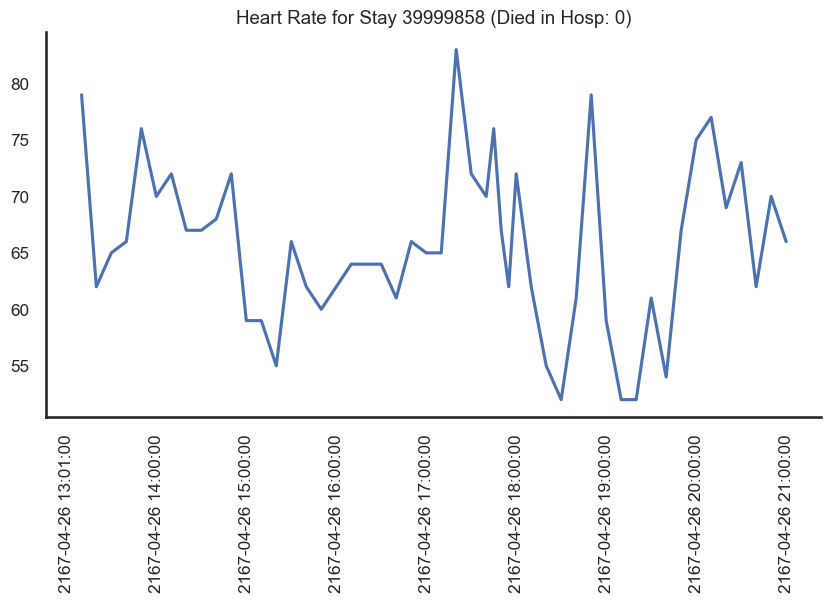

In [21]:
# example heart rate for a stay (irregular time series)
stay_id = 39999858
died_in_hospital = df_patient.loc[df_patient['stay_id'] == stay_id, 'died_in_hosp'].values[0]
df_vital_stay = df_vital[df_vital['stay_id'] == stay_id]
df_heartrate_stay = df_vital_stay[df_vital_stay['variable'] == 'heart rate']
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_heartrate_stay['charttime'], df_heartrate_stay['value'])
ax.set_title(f'Heart Rate for Stay {stay_id} (Died in Hosp: {died_in_hospital})')
ax.set_xticklabels(df_heartrate_stay['charttime'], rotation=90)
plt.show()